# Generative Adversarial Networks

This is an example of how a GAN works in a 1 dimension experiment. We are going to use some values given by a unknown distribution for the generator and the discrimanator. These values are going to be used by the discriminator to know how real values are. In the other hand, the generator is going to use random values generated, for example, from a noisy distribution and it will try to fool the discrimnator. Discriminator will have as inputs both real values and fake values generated by the Generator.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plots
import seaborn as sns # for pretty plots
from scipy.stats import norm

The samples will be token from a normal distribution and they will be used to train the neural network.

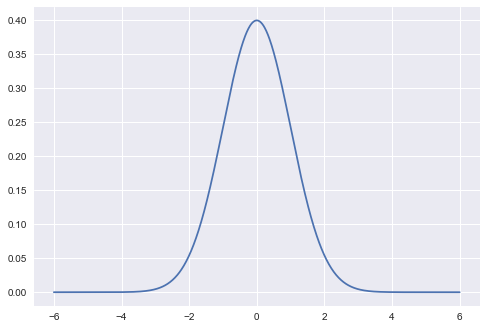

In [2]:
mu,sigma = 0,1
linespace = np.linspace(-6,6,1000)
plots.plot(linespace, norm.pdf(linespace, loc=mu, scale=sigma))
plots.show()

Now, in this step we are going to define the Multilayer Perceptron. This neural network allow us to map a set of input data onto a set of appropiate outputs. It consist of multiple layers of nodes in a direct graph. Each layer is fully conected with the next one. In this particular case, this neural network is going to have different learnable parameters.

In [3]:
# As have been said before, this function allow us to choose the correct number of ouputs we want.
def MultilayerPerceptron(input, output_dimension):
    w1 = tf.get_variable("w0", [input.get_shape()[1], 7], initializer= tf.random_normal_initializer())
    b1 = tf.get_variable("b0", [7], initializer = tf.constant_initializer(0.0))
    w2 = tf.get_variable("w1", [7, 5], initializer = tf.random_normal_initializer())
    b2 = tf.get_variable("b1", [5], initializer = tf.constant_initializer(0.0))
    w3 = tf.get_variable("w2", [5, output_dimension], initializer = tf.random_normal_initializer())
    b3 = tf.get_variable("b2", [output_dimension], initializer = tf.constant_initializer(0.0))
    # Now we will define the operators
    op1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    op2=tf.nn.tanh(tf.matmul(op1,w2)+b2)
    op3=tf.nn.tanh(tf.matmul(op2,w3)+b3)
    return op3, [w1,b1,w2,b2,w3,b3]

In this step we are going to define the function that will allow the learning process to search for better values of the learnable parameters

In [4]:
train_iterations=20000
def optimizer(loss, varlist):
    batch = tf.Variable(0)
    rateoflearning = tf.train.exponential_decay(0.001,batch,train_iterations // 4, 0.95, staircase = True)
    optimizer = tf.train.MomentumOptimizer(rateoflearning,0.6).minimize(loss,global_step = batch, var_list = varlist)
    return optimizer

At this moment we have both the Multilayer Perceptron and the optimizer function. Now is a good moment to define a pre training process for the discriminator. This will help it to have a base in order to not start knowing nothing and this will reduce the time of convergence. From a math point of view, this process will help the discriminator to have a distribution function more similar to the original one that we will use to generate the real samples. 

In [5]:
# First of all we are going to define the size of the minibatch that will be used as input in each iteration
M=200

In [6]:
# Now we are going to define a special discriminator different from the original one
with tf.variable_scope("trainedD"):
    # This will take the input in a Mx1 dimension (200x1) which is the batch size
    input_node = tf.placeholder(tf.float32, shape=(M,1)) 
    # Same size than the batch. As many labels as possible values.
    labels = tf.placeholder(tf.float32, shape=(M,1)) 
    # The batch as input and only 1 output
    D,output = MultilayerPerceptron(input_node, 1) 
    lossfunction = tf.reduce_mean(tf.square(D-labels))

In [7]:
optimizer_pre=optimizer(lossfunction,None)

In [8]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

As it follows, we are going to define a plot function in order to see how the decision boundary is for a linspace of samples in a defined range. It is easy to think that the results are going to be different in each execution because the learneable parameters are random at the beginning. This parameters are initialized when run the session variable D with the input_node x which is a node that contains the samples mentioned at the beginning of this paragraph.

In [9]:
# plot decision surface
def plot_function(D,input_node):
    figure,axis=plots.subplots(1)
    # original distribution
    xaxis=np.linspace(-6,6,1000)
    axis.plot(xaxis, norm.pdf(xaxis,loc=mu,scale=sigma), label='p_distribution')
    # decision boundary
    r=1000 # r is the resolution. It's a good thing to use the same that was used at the beginning with the original distribution
    xaxis=np.linspace(-6,6,r)
    # decision space where the algorithm is going to save initial decisor values
    decisor_beginning=np.zeros((r,1)) 
    for i in range(int(r/M)):
        x=np.reshape(xaxis[M*i:M*(i+1)],(M,1))
        decisor_beginning[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    axis.plot(xaxis, decisor_beginning, label='decision boundary', color ='black')
    axis.set_ylim(0,1.1)
    plots.legend()

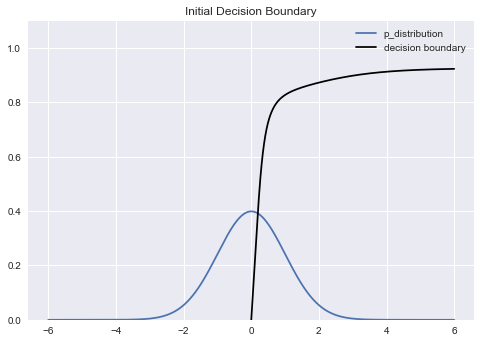

<class 'NoneType'>


In [10]:
plot_function(D,input_node)
plots.title('Initial Decision Boundary')
print(type(plots.show()))

In [11]:
loss_function_training=np.zeros(1000)
for i in range(1000):
    d=(np.random.random(M)-0.5) * 10.0 
    # We do this in order to sample from all the domain and not only from the gaussian distribution
    labelsnew=norm.pdf(d,loc=mu,scale=sigma)
    loss_function_training[i],_=sess.run([lossfunction,optimizer_pre], {input_node: np.reshape(d,(M,1)), labels: np.reshape(labelsnew,(M,1))})

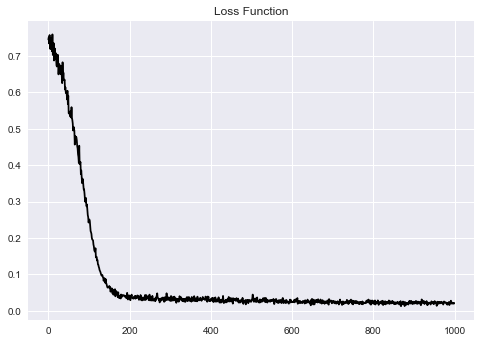

In [12]:
# Loss function with training
plots.plot(loss_function_training, color ='black')
plots.title('Loss Function')
plots.show()

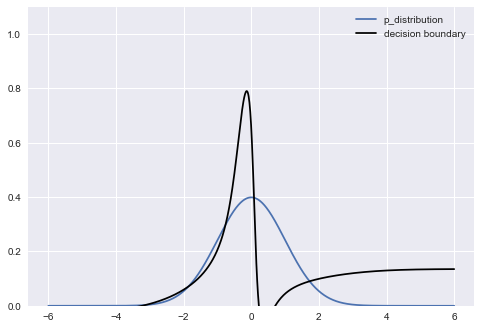

In [13]:
plot_function(D,input_node)
plots.show()

In [14]:
learned_weights = sess.run(output)
# Here we are saving the weiights learned by the pretraining

In [15]:
sess.close()

# Generator and Discriminator

In [16]:
with tf.variable_scope("Generator"):
    z_input_node = tf.placeholder(tf.float32, shape=(M,1))
    Generator,output_gen = MultilayerPerceptron(z_input_node,1)
    # We have to rescale by 6 to match the range between possible values 
    # because z values goes from 0 to 1 and the range of X is bigger
    Generator = tf.multiply(6.0,Generator)
    
with tf.variable_scope("Discriminator") as scope:
    # We have to define two different discriminators. One of them will have real
    # values as input, and the other the fake values generated by the generator
    # This allow us to reuse the same learnable values for both
    x_input_node = tf.placeholder(tf.float32, shape=(M,1))
    op, output_dis = MultilayerPerceptron(x_input_node,1)
    Discriminator1 = tf.maximum(tf.minimum(op,0.99), 0.01) #boundaries for the values
    scope.reuse_variables()
    op,output_dis = MultilayerPerceptron(Generator, 1)
    Discriminator2 = tf.maximum(tf.minimum(op,0.99), 0.01)


At this point we have defined what is a generator a what is a discriminator. In the moment we run the code Generator, Discriminator1 and Discriminator2 will have the result of apliying the multilayer percpetron which are the weighted values after passing the 3 layers. This values will be changing while learnables variables change. Now we have to say the network how to improve this learnable values. For that we have to use the teorethical formula

In [17]:
discriminator_objective = tf.reduce_mean(tf.log(Discriminator1)+tf.log(1-Discriminator2))
generator_objective = tf.reduce_mean(tf.log(Discriminator2))
lossfunction_dis = 1 - discriminator_objective
lossfunction_gen = 1 - generator_objective
optimized_discriminator = optimizer(lossfunction_dis, output_dis)
optimized_generator = optimizer(lossfunction_gen, output_gen)

In [18]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [19]:
for i,v in enumerate(output_dis):
    sess.run(v.assign(learned_weights[i]))

In [20]:
def plot_function2():
    # plots data generated, original distribution, decision boundary 
    figure,axis=plots.subplots(1)
    # original distribution
    xaxis=np.linspace(-6,6,1000)
    axis.plot(xaxis, norm.pdf(xaxis,loc=mu,scale=sigma), label='p_original_distribution')

    # decision boundary
    r=1000 # resolution (number of points)
    xaxis=np.linspace(-6,6,r)
    decisor=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(int(r/M)):
        x=np.reshape(xaxis[M*i:M*(i+1)],(M,1))
        decisor[M*i:M*(i+1)]=sess.run(Discriminator1,{x_input_node: x})

    axis.plot(xaxis, decisor, label='decision boundary',color='black')

    # data generated
    zs=np.linspace(-6,6,r)
    generated=np.zeros((r,1)) # generator function
    for i in range(int(r/M)):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        generated[M*i:M*(i+1)]=sess.run(Generator,{z_input_node: z})
    histo_gendata, binedges = np.histogram(generated)
    axis.plot(np.linspace(-6,6,10), histo_gendata/float(r), label='data_generated',color ='yellow')

    # ylim, legend
    axis.set_ylim(0,1.1)
    plots.legend()

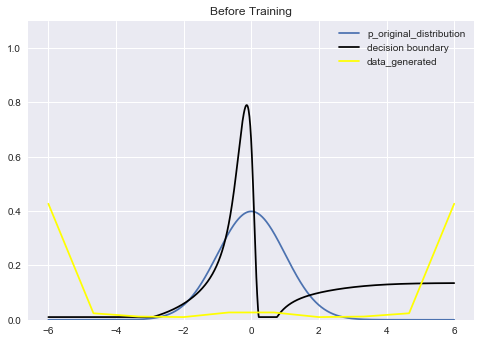

In [21]:
plot_function2()
plots.title('Before Training')
plots.show()

In [22]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histdis, histgen= np.zeros(train_iterations), np.zeros(train_iterations)
for i in range(train_iterations):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-6.0,6.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histdis[i],_=sess.run([discriminator_objective,optimized_discriminator], {x_input_node: np.reshape(x,(M,1)), z_input_node: np.reshape(z,(M,1))})
    z= np.linspace(-6.0,6.0,M)+np.random.random(M)*0.01 # sample noise prior
    histgen[i],_=sess.run([generator_objective,optimized_generator], {z_input_node: np.reshape(z,(M,1))}) # update generator

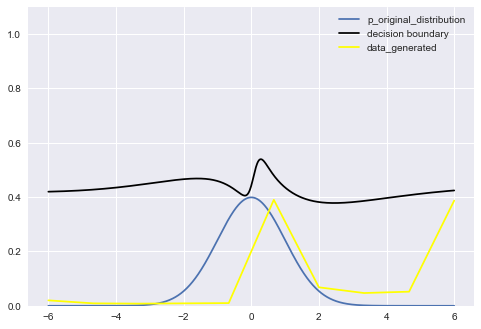

In [23]:
plot_function2()
plots.show()